In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Convolution2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D

import kapre 
from kapre.time_frequency import Spectrogram

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Using TensorFlow backend.


In [2]:
A01T = h5py.File('/home/carla/Downloads/project_datasets/project_datasets/A01T_slice.mat','r')
data = np.copy(A01T['image'])
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

In [3]:
#check the data dimensionality
print data.shape
print labels.shape
#data = np.swapaxes(data, 1,2)
data = data[:,:22,:]
print data.shape
print labels.shape
print len(np.argwhere(labels == 769))

(288, 25, 1000)
(288,)
(288, 22, 1000)
(288,)
72


In [4]:
buf = np.zeros([288,22,24])
print buf.shape 
print data.shape
databuf = np.concatenate([data,buf],axis=2)
print databuf.shape

(288, 22, 24)
(288, 22, 1000)
(288, 22, 1024)


In [5]:
# Check min and max values
print np.min(data)
print np.max(data)
print len(np.argwhere(np.isnan(data)))
#print np.argwhere(np.isnan(data))

nan
nan
48


In [6]:
data[np.isnan(data)] = 92.5
print np.argwhere(np.isnan(data))

[]


In [7]:
#one-hot-encode the data for use with categorical_crossentropy
labels_cata = labels - 769
print labels_cata
labels_cata = to_categorical(labels_cata, num_classes=4)
print labels_cata

[3 2 1 0 0 1 2 3 1 2 0 0 0 3 1 1 0 0 2 0 1 3 3 2 0 3 3 1 3 3 1 0 1 2 2 2 3
 2 0 3 1 2 1 2 3 1 2 0 0 0 3 1 0 2 0 2 1 3 0 2 2 0 2 1 3 3 3 2 0 3 1 3 1 0
 2 1 0 2 2 0 2 3 3 1 0 1 3 1 3 2 1 1 1 2 3 0 1 3 0 2 2 3 0 0 2 1 3 3 3 1 0
 2 1 3 0 3 2 1 3 3 0 1 1 2 3 1 0 0 3 1 0 2 1 1 2 0 3 2 2 2 2 0 1 0 1 0 0 2
 2 1 2 3 0 3 0 0 1 3 2 1 3 2 3 2 3 1 1 3 0 1 1 1 2 3 0 3 0 2 0 3 0 2 0 1 2
 2 3 0 1 3 1 2 2 0 3 1 3 0 0 2 2 1 3 1 1 0 1 3 3 1 1 1 1 3 3 2 3 0 1 2 1 0
 3 0 3 0 0 0 0 2 2 3 1 2 2 2 3 2 0 2 0 3 1 3 3 2 3 3 2 1 3 2 0 1 1 1 2 1 3
 2 3 1 2 0 3 0 2 3 0 2 0 1 1 0 3 0 3 2 2 0 2 1 1 0 2 0 1 0]
[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]


In [9]:
# Stacked LSTM model
model = Sequential()
model.add(LSTM(10, input_shape=(1000,22),return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(data, labels_cata, nb_epoch=3, batch_size=10, verbose=1, validation_split=0.1)
print(model.summary())

In [10]:
# Model from thesis paper
model = Sequential()
model.add(LSTM(128, input_shape=(1000,22)))
model.add(Dropout(0.3))
model.add(Dense(4,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(data, labels_cata, nb_epoch=10, batch_size=100, verbose=1, validation_split=0.1)
print(model.summary())

In [8]:
#STFT CNN

SR = 250
src_cute, _ = librosa.load(r'/home/carla/Downloads/SampleAudio_0.4mb.mp3', sr=SR, mono=True)
print src_cute.shape

def print_info():
    print('%s/%s/%s' % (now.year, now.month, now.day))
    print('librosa version: {}'.format(librosa.__version__))
    print('Keras version: {}'.format(keras.__version__))
    if keras.backend._BACKEND == 'tensorflow':
        import tensorflow
        print('Keras backend: {}: {}'.format(keras.backend._backend, tensorflow.__version__))
    elif keras.backend._BACKEND == 'theano':
        import theano
        print('Keras backend: {}: {}'.format(keras.backend._backend, theano.__version__))
    print('Keras image data format: {}'.format(keras.backend.image_data_format()))
    print('Kapre version: {}'.format(kapre.__version__))
    print('\nSampling rate: {} Hz'.format(SR))

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])
    
    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    print model.output_shape
    output_shape = (2,64,64,1)
    model.compile('sgd', 'mse')
    np.random.seed(42)
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, data, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print "Channels"
    print model.input_shape[1:]
#     src, _ = librosa.load(r'/home/carla/Downloads/SampleAudio_0.4mb.mp3', sr=SR, mono=True)
#     print "src Shape"
#     print src.shape 
    src = data 
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    print src_batch.shape
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    
    if logam:
        result = librosa.amplitude_to_db(result)
    display.specshow(result, 
                     y_axis='linear', sr=SR)

(6936,)


In [9]:
print_info()

2018/3/8
librosa version: 0.6.0
Keras version: 2.1.4
Keras backend: tensorflow: 1.5.0
Keras image data format: channels_last
Kapre version: 0.1.3

Sampling rate: 250 Hz


In [54]:
###Fix input dimensionality 
src = data[0]
print src.shape

(22, 1000)


srcshape
(1, 1024)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
trainable_stft (Spectrogr (None, 513, 64, 1)        1050624     
Total params: 1,050,624
Trainable params: 1,050,624
Non-trainable params: 0
________________________________________________________________________________
(None, 513, 64, 1)
Epoch 1/1
2/2 [==============================] - 0s 208ms/step - loss: 1351.0537
Channels
(1, 1024)
(1, 1, 1024)
771


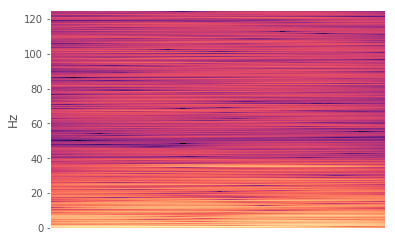

In [19]:
src = np.random.random((1, SR * 3))
src = databuf[0,0,:]
src = src[np.newaxis, :] 
print "srcshape"
print src.shape
model = Sequential()
model.add(Spectrogram(n_dft=1024, n_hop=16, input_shape=src.shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))

check_model(model)
visualise_model(model, src)
print labels[1]

In [21]:
src = np.random.random((1, SR * 3))
src = data[0]
#src = src[np.newaxis, :] 
print "srcshape"
print src.shape
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=8, input_shape=src.shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))
model.add(Convolution2D(24,(12, 12)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.5))


check_model(model)
#visualise_model(model, src)
print labels[1]

srcshape
(22, 1000)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
trainable_stft (Spectrogr (None, 257, 125, 22)      263168      
________________________________________________________________________________
conv2d_5 (Conv2D)         (None, 246, 114, 24)      76056       
________________________________________________________________________________
batch_normalization_5 (Ba (None, 246, 114, 24)      96          
________________________________________________________________________________
max_pooling2d_5 (MaxPooli (None, 82, 38, 24)        0           
________________________________________________________________________________
activation_5 (Activation) (None, 82, 38, 24)        0           
________________________________________________________________________________
dropout_5 (Dropout)       (None, 82, 38, 24)        0           
Total params: 339,320
Trainable params:

ResourceExhaustedError: OOM when allocating tensor with shape[2,24,246,114] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_6/SGD/gradients/max_pooling2d_5/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, _class=["loc:@max_pooling2d_5/MaxPool"], data_format="NHWC", ksize=[1, 3, 3, 1], padding="VALID", strides=[1, 3, 3, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_5/cond/Merge, max_pooling2d_5/MaxPool, training_6/SGD/gradients/activation_5/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op u'training_6/SGD/gradients/max_pooling2d_5/MaxPool_grad/MaxPoolGrad', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/carla/Documents/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-440e76eddd71>", line 17, in <module>
    check_model(model)
  File "<ipython-input-7-8156ea262b3c>", line 30, in check_model
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/models.py", line 963, in fit
    validation_steps=validation_steps)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/engine/training.py", line 1689, in fit
    self._make_train_function()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/optimizers.py", line 168, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 2512, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 609, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 375, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 609, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_grad.py", line 583, in _MaxPoolGrad
    data_format=op.get_attr("data_format"))
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 3291, in _max_pool_grad
    data_format=data_format, name=name)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op u'max_pooling2d_5/MaxPool', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 18 identical lines from previous traceback]
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-440e76eddd71>", line 12, in <module>
    model.add(MaxPooling2D(pool_size = (3, 3)))
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/models.py", line 492, in add
    output_tensor = layer(self.outputs[0])
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/layers/pooling.py", line 158, in call
    data_format=self.data_format)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/layers/pooling.py", line 221, in _pooling_function
    pool_mode='max')
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 3654, in pool2d
    data_format=tf_data_format)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 2043, in max_pool
    name=name)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 3018, in _max_pool
    data_format=data_format, name=name)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[2,24,246,114] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_6/SGD/gradients/max_pooling2d_5/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, _class=["loc:@max_pooling2d_5/MaxPool"], data_format="NHWC", ksize=[1, 3, 3, 1], padding="VALID", strides=[1, 3, 3, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_5/cond/Merge, max_pooling2d_5/MaxPool, training_6/SGD/gradients/activation_5/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

